In [3]:
import torchvision.models as models
import torch
import json
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from PIL import Image
from torchvision import transforms
import csv

In [4]:
network = models.resnet50(pretrained=True)

In [5]:

images = []
with open('mapping.txt', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        input_image = Image.open("data/" + row[0])
        row.append(input_image)
        images.append(row)
print(images)

[['bullet_train_1.jpg', 'bullet_train', '466', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7F23E442B6A0>], ['car_wheel_1.jpg', 'car_wheel', '479', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=844x569 at 0x7F2309D38640>], ['electric_locomotive_1.jpg', 'electric_locomotive', '547', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x325 at 0x7F2309D38730>], ['guacamole_1.jpg', 'guacamole', '924', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x628 at 0x7F2309D38940>], ['power_drill_1.jpg', 'power_drill', '740', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=702x395 at 0x7F2309D389D0>], ['red_wine_1.jpg', 'red_wine', '966', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x640 at 0x7F2309D38A30>], ['rifle_1.jpg', 'rifle', '764', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x525 at 0x7F2309D38D90>], ['samoyed_1.jpg', 'samoyed', '258', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=729x486 at 0x7F230

In [6]:
with open('imagenet1000_clsid_to_human.json') as json_file:
    class_idx = json.load(json_file)
    labels = {int(key): value for key, value in class_idx.items()}

<Figure size 432x288 with 0 Axes>

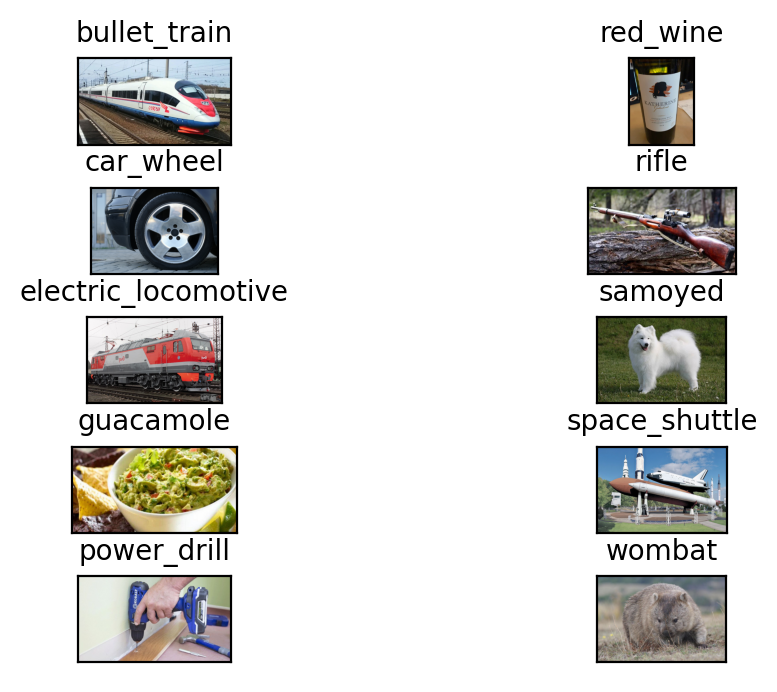

In [7]:
plt.figure()
f, axarr = plt.subplots(5,2, dpi=200) 
for i in range(10):
    y = i // 5
    x = i % 5
    input_image = Image.open("data/" + images[i][0])
    axarr[x, y].axes.get_xaxis().set_visible(False)
    axarr[x, y].axes.get_yaxis().set_visible(False)
    axarr[x, y].imshow(images[i][3])
    axarr[x, y].set_title(images[i][1], fontsize=10)
    plt.subplots_adjust(wspace=None, hspace=0.5)

In [8]:
def transform_image(image):
    centre_crop = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    input_tensor = centre_crop(image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

def inverse_transform(image):
    inv = transforms.Compose([ 
        transforms.Normalize([ 0., 0., 0. ],[ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize([ -0.485, -0.456, -0.406 ],[ 1., 1., 1. ]),])
    return inv(image)

def predict(image, network, raw_image=True):
    #use raw image, it will transform it
    #return: array of probability for each class
    input_batch = image
    if raw_image:
        input_batch = transform_image(image)
    with torch.no_grad():
        network.eval()
        prediction = network(input_batch)  
    return prediction.data.numpy()

def probabilty_of_class(image, class_index, network, raw_image=True):
    prediction = predict(image, network, raw_image)
    return prediction[0,class_index]

def get_most_probable_class(image, network, raw_image=True):
    #returns index and class name
    prediction = predict(image, network, raw_image)
    index = prediction.argmax()
    return(index, labels[index])

<Figure size 432x288 with 0 Axes>

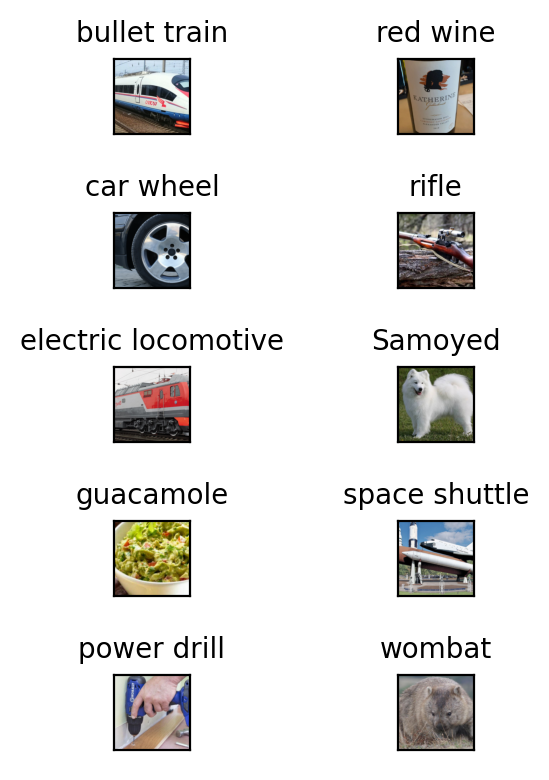

In [76]:
plt.figure()
f, axarr = plt.subplots(5,2, dpi=200) 
to_image = transforms.ToPILImage()
for i in range(10):
    y = i // 5
    x = i % 5
    input_image = transform_image(images[i][3])
    axarr[x, y].imshow(inverse_transform(input_image[0]).permute(1, 2, 0).detach().numpy() )
    axarr[x, y].axes.get_xaxis().set_visible(False)
    axarr[x, y].axes.get_yaxis().set_visible(False)
    index, label = get_most_probable_class(input_image, network, False)
    axarr[x, y].set_title(label.split(",")[0], fontsize=10)
    plt.tight_layout()

In [11]:
for i in images:
    i[3] = transform_image(i[3])

/usr/lib/python3.9/site-packages/torchvision/transforms/transforms.py:207: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [9]:

get_most_probable_class(images[0][3], network, False)

(466, 'bullet train, bullet')

In [66]:
def fast_gradient_attack(image, correct_prediction_index, epsilon, network_to_attack, iteration_count = 1):
    #return image, probability before and probabilty 
    changed_image = image
    prev_prob = probabilty_of_class(changed_image, correct_prediction_index, network_to_attack, False)
    if iteration_count == -1:
        iteration_count = 100
    for i in tqdm(range(iteration_count)):
        predict_index = get_most_probable_class(changed_image, network, False)[0]
        if predict_index != correct_prediction_index:
            break
        network.eval()
        image.requires_grad = True
        prediction = network_to_attack(image)

        loss = F.nll_loss(prediction, torch.tensor([correct_prediction_index]))

        network.zero_grad()
        loss.backward()

        data_grad = image.grad.data
        print(image.grad.data)

        changed_image = changed_image + epsilon * data_grad.sign()

        changed_image = changed_image.clamp(-3, 3)
        new_prob = probabilty_of_class(changed_image, correct_prediction_index, network_to_attack, False)
    return (changed_image, prev_prob, new_prob)

In [29]:
res, prev, new = fast_gradient_attack(images[0][3], 466, 0.35, network)

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

tensor([[[[-0.0351, -0.0326, -0.0422,  ..., -0.0043, -0.0035, -0.0041],
          [ 0.0010, -0.0098, -0.0127,  ...,  0.0066, -0.0059, -0.0021],
          [ 0.0172,  0.0184, -0.0214,  ..., -0.0089, -0.0112, -0.0040],
          ...,
          [ 0.0008, -0.0123,  0.0269,  ..., -0.0010, -0.0192, -0.0221],
          [-0.0057,  0.0090,  0.0042,  ...,  0.0162,  0.0169, -0.0160],
          [-0.0057,  0.0009, -0.0103,  ..., -0.0127,  0.0167,  0.0402]],

         [[-0.0790, -0.0749, -0.0774,  ..., -0.0161, -0.0093, -0.0016],
          [-0.0410, -0.0551, -0.0647,  ..., -0.0030, -0.0119,  0.0002],
          [-0.0262, -0.0455, -0.1201,  ..., -0.0262, -0.0191, -0.0043],
          ...,
          [ 0.0021, -0.0188,  0.0281,  ..., -0.0080, -0.0206, -0.0278],
          [-0.0093,  0.0057,  0.0011,  ...,  0.0230,  0.0211, -0.0286],
          [-0.0069,  0.0010, -0.0128,  ..., -0.0196,  0.0156,  0.0379]],

         [[-0.0359, -0.0218, -0.0222,  ..., -0.0063, -0.0064,  0.0019],
          [-0.0073, -0.0092, -

In [378]:
get_most_probable_class(res, network, False)

(565, 'freight car')

In [286]:
print(images[0][3][0].min())

tensor(-2.0323, grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


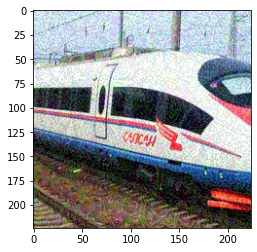

In [379]:
plt.imshow(inverse_transform(res[0]).permute(1, 2, 0).detach().numpy())

In [19]:
import copy

def DeepFool(input_batch, correct_prediction_index, epsilon, network_to_attack, iteration_count = 1):
    batch = input_batch.detach().clone()
    batch.requires_grad = True
    network.eval()
    prediction = network(batch)
    prediction_idx = correct_prediction_index
    new_prediction_idx = prediction_idx
    iterations = 0
    prev_prob = probabilty_of_class(input_batch, correct_prediction_index, network_to_attack, False)
    while correct_prediction_index == new_prediction_idx:
        prediction_value = prediction[0,prediction_idx]
        batch.retain_grad()
        prediction_value.backward(retain_graph=True)
        grad_preciction = batch.grad.detach().clone()
        batch.grad.data.zero_()

        w = torch.zeros_like(batch)
        f = torch.empty([1])
        ratio = 0
        n = prediction.shape[1]

        for c in tqdm(range(n)):
            if c != prediction_idx:
                prediction_c = prediction[0,c]
                batch.retain_grad()
                prediction_c.backward(retain_graph=True)
                grad_c = batch.grad.detach().clone()
                batch.grad.data.zero_()
                w_ = grad_c - grad_preciction
                f_ = prediction_c - prediction_value
                if c == 0 or (prediction_idx == 0 and c == 1):
                    f = f_
                    w = w_
                    ratio = torch.abs(f_) / torch.linalg.norm(w_)
                elif torch.abs(f_) / torch.linalg.norm(w_) < ratio:
                    f = f_
                    w = w_
                    ratio = torch.abs(f_) / torch.linalg.norm(w_)
    
        new_batch = batch.detach().clone()
        new_batch.requires_grad_(False)
        new_batch += ratio * (w > 0).type(torch.float32) * torch.abs(w)
        new_batch -= ratio * (w < 0).type(torch.float32) * torch.abs(w)
        new_batch.requires_grad_(True)

        network_to_attack.eval()
        prediction = network_to_attack(new_batch)
        new_prediction_idx = prediction.data.numpy().argmax()
        batch = new_batch
        iterations+=1
        new_prob = probabilty_of_class(batch, correct_prediction_index, network_to_attack, False)
    return (batch, prev_prob, new_prob)

In [20]:
res, prev, new = DeepFool(images[0][3], 466, 0.35, network)

  2%|▏         | 21/1000 [00:03<02:57,  5.51it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(705, 'passenger car, coach, carriage') 20.354372 18.175863


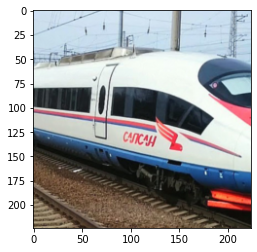

In [123]:
print(get_most_probable_class(res, network, False), prev, new)
plt.imshow(inverse_transform(res[0]).permute(1, 2, 0).detach().numpy())

In [65]:
from tqdm import tqdm

def simba_attack(image, correct_prediction_index, epsilon, network_to_attack, iteration_count = 1000):
    result = image
    result.requires_grad = False
    size = result.shape[1] * result.shape[2] * result.shape[3]
    perm = torch.randperm(size)
    prev_prob = probabilty_of_class(result, correct_prediction_index, network_to_attack, False)
    start_prob = prev_prob
    if iteration_count == -1:
        iteration_count = 25000
    for i in tqdm(range(iteration_count)):
        predict_index = get_most_probable_class(result, network, False)[0]
        if predict_index != correct_prediction_index:
            break
        to_add = torch.zeros(size)
        to_add[perm[i]] = epsilon
        to_add = to_add.view(result[0].size()).clamp(-3, 3)
        result[0] += to_add
        new_prob = probabilty_of_class(result, correct_prediction_index, network_to_attack, False)
        if(new_prob < prev_prob):
            prev_prob = new_prob
        else:
            changed_image = result
            changed_image[0] -= 2*to_add
            new_prob = probabilty_of_class(result, correct_prediction_index, network_to_attack, False)
            if(new_prob < prev_prob):
                prev_prob = new_prob
            else:
                result[0] += to_add
    return (result, start_prob, prev_prob) 
    

In [90]:
res, prev, new = simba_attack(res, 466, 0.3, network, 1500)

RuntimeError: you can only change requires_grad flags of leaf variables. If you want to use a computed variable in a subgraph that doesn't require differentiation use var_no_grad = var.detach().

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(705, 'passenger car, coach, carriage') 14.18751 14.18751


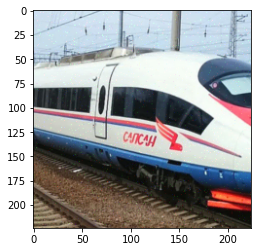

In [356]:
print(get_most_probable_class(res, network, False), prev, new)
plt.imshow(inverse_transform(res[0]).permute(1, 2, 0).detach().numpy())

In [21]:
attacks_algorithms_name = ["DeepFool"] #['fast gradient attack', 'simba']
attacks_algorithms = [DeepFool]#[fast_gradient_attack, simba_attack]
result = []
for i in range(len(images)):
    result.append([])
    for j in range(len(attacks_algorithms)):
        res, prev, new = attacks_algorithms[j](images[i][3], int(images[i][2]), 0.3, network, -1)
        result[i].append((attacks_algorithms_name[j], res, prev, new))

100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


In [57]:
import pickle
with open('resultDeepFool.pkl', 'wb') as f:
    pickle.dump(result, f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10
1


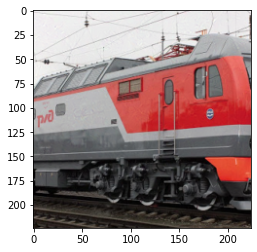

In [30]:
print(len(result))
print(len(result[0]))

for i in result[:3]:
    for j in i:
        plt.imshow(inverse_transform(j[1][0]).permute(1, 2, 0).detach().numpy())

In [36]:

print(get_most_probable_class(result[0][0][1], network, False), prev, new)

tensor([[[[ 1.4219,  1.4258,  1.4422,  ...,  1.2898,  1.2897,  1.2897],
          [ 1.4399,  1.4236,  1.4234,  ...,  1.2735,  1.2895,  1.2726],
          [ 1.3902,  1.3886,  1.4240,  ...,  1.2550,  1.2891,  1.2554],
          ...,
          [-0.2501, -0.8503, -0.5571,  ..., -1.3991, -1.2788, -1.2616],
          [ 0.0572, -0.3024, -0.0964,  ..., -1.6383, -1.6209, -1.5019],
          [ 0.7933,  0.7930,  0.8793,  ..., -1.3991, -1.5356, -1.6374]],

         [[ 1.8799,  1.8849,  1.9194,  ...,  1.8674,  1.8677,  1.8509],
          [ 1.8987,  1.8826,  1.9001,  ...,  1.8335,  1.8499,  1.8333],
          [ 1.8482,  1.8463,  1.8834,  ...,  1.7967,  1.8493,  1.8155],
          ...,
          [-0.4070, -1.0219, -0.7212,  ..., -1.3361, -1.1952, -1.1604],
          [-0.0921, -0.4434, -0.2328,  ..., -1.5804, -1.5274, -1.4063],
          [ 0.6611,  0.6777,  0.7825,  ..., -1.3185, -1.4230, -1.5444]],

         [[ 2.3757,  2.3790,  2.3786,  ...,  2.3955,  2.3781,  2.3788],
          [ 2.3950,  2.3784,  

In [26]:
plt.imshow(inverse_transform(result[0][0][0]).permute(1, 2, 0).detach().numpy())

TypeError: tensor is not a torch image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

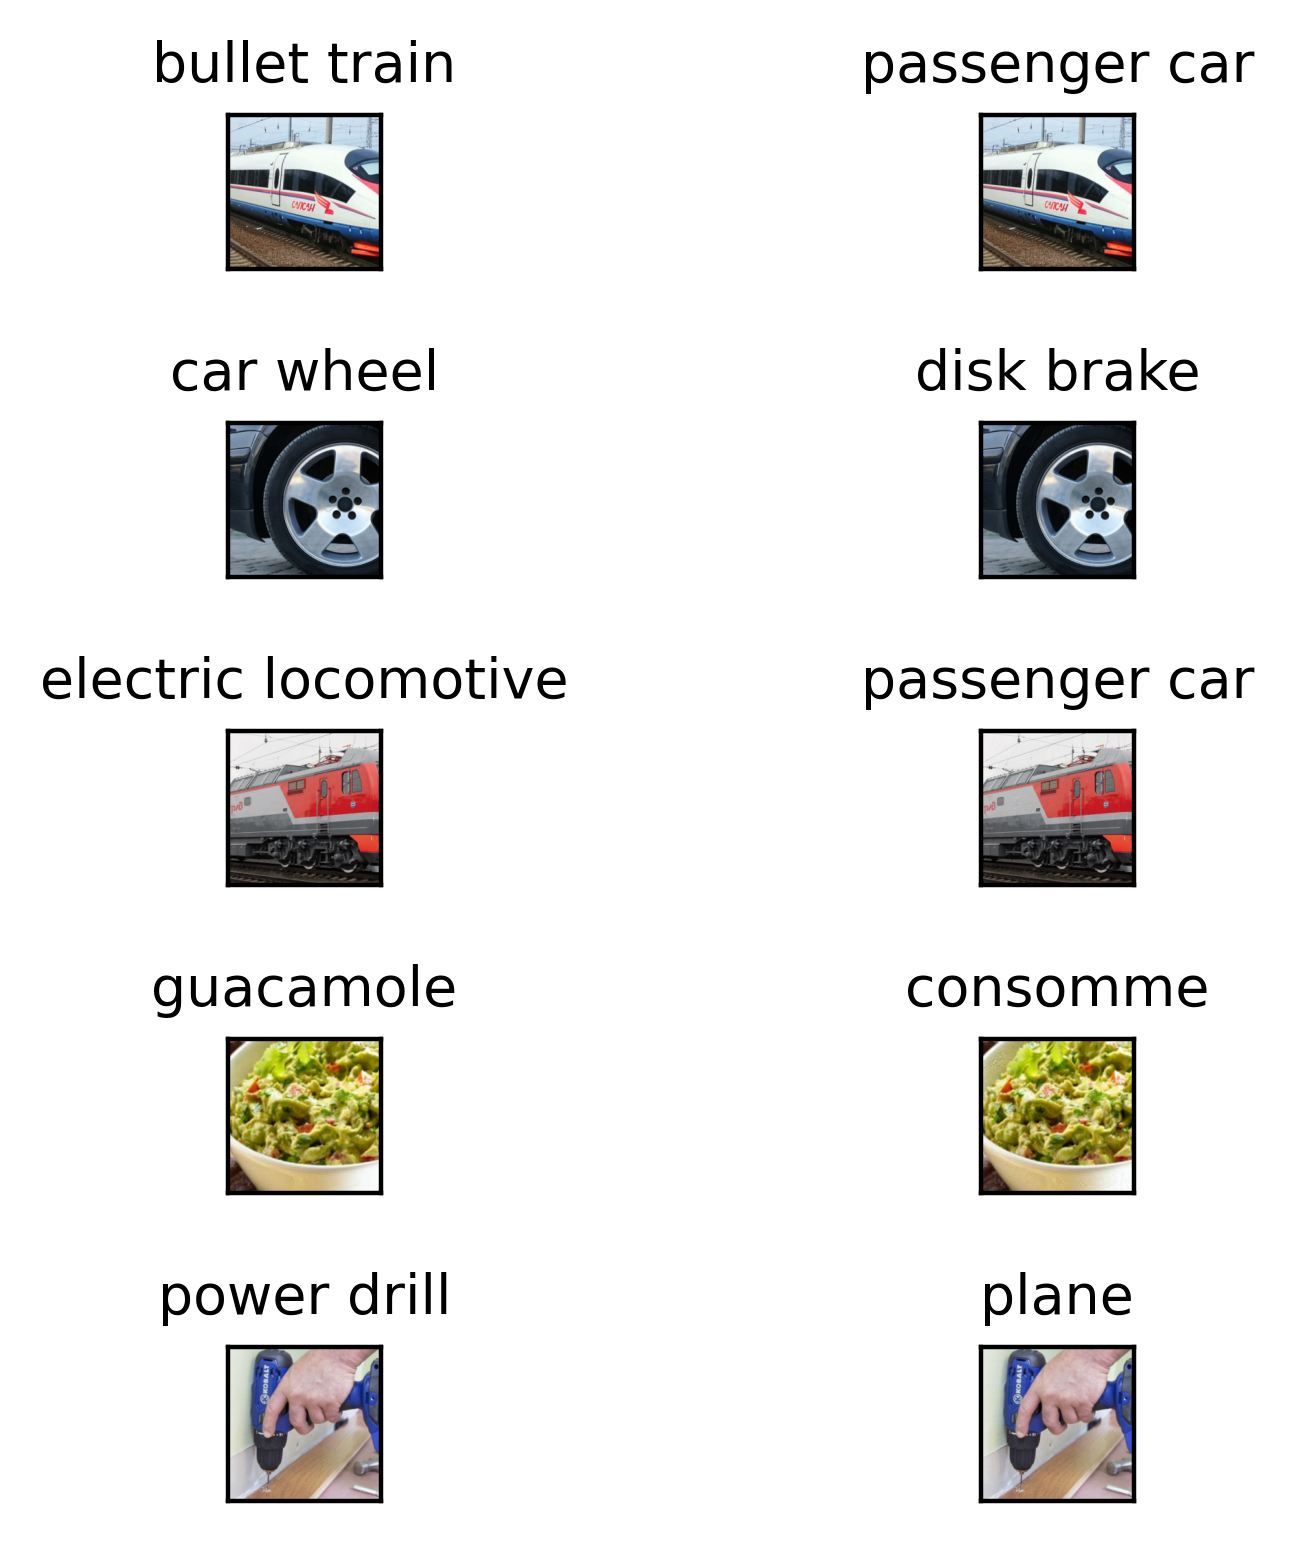

In [54]:
plt.figure()
f, axarr = plt.subplots(5,2, dpi=400) 
to_image = transforms.ToPILImage()
for i in range(5):
    axarr[i, 0].imshow(inverse_transform(images[i][3][0]).permute(1, 2, 0).detach().numpy() )
    axarr[i, 0].axes.get_xaxis().set_visible(False)
    axarr[i, 0].axes.get_yaxis().set_visible(False)
    index, label = get_most_probable_class(images[i][3], network, False)
    axarr[i, 0].set_title(label.split(",")[0], fontsize=10)
    for j in range(len(attacks_algorithms)):
        axarr[i, j+1].imshow(inverse_transform(result[i][j][1][0]).permute(1, 2, 0).detach().numpy() )
        axarr[i, j+1].axes.get_xaxis().set_visible(False)
        axarr[i, j+1].axes.get_yaxis().set_visible(False)
        index, label = get_most_probable_class(result[i][j][1], network, False)
        axarr[i, j+1].set_title(label.split(",")[0], fontsize=10)
        plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

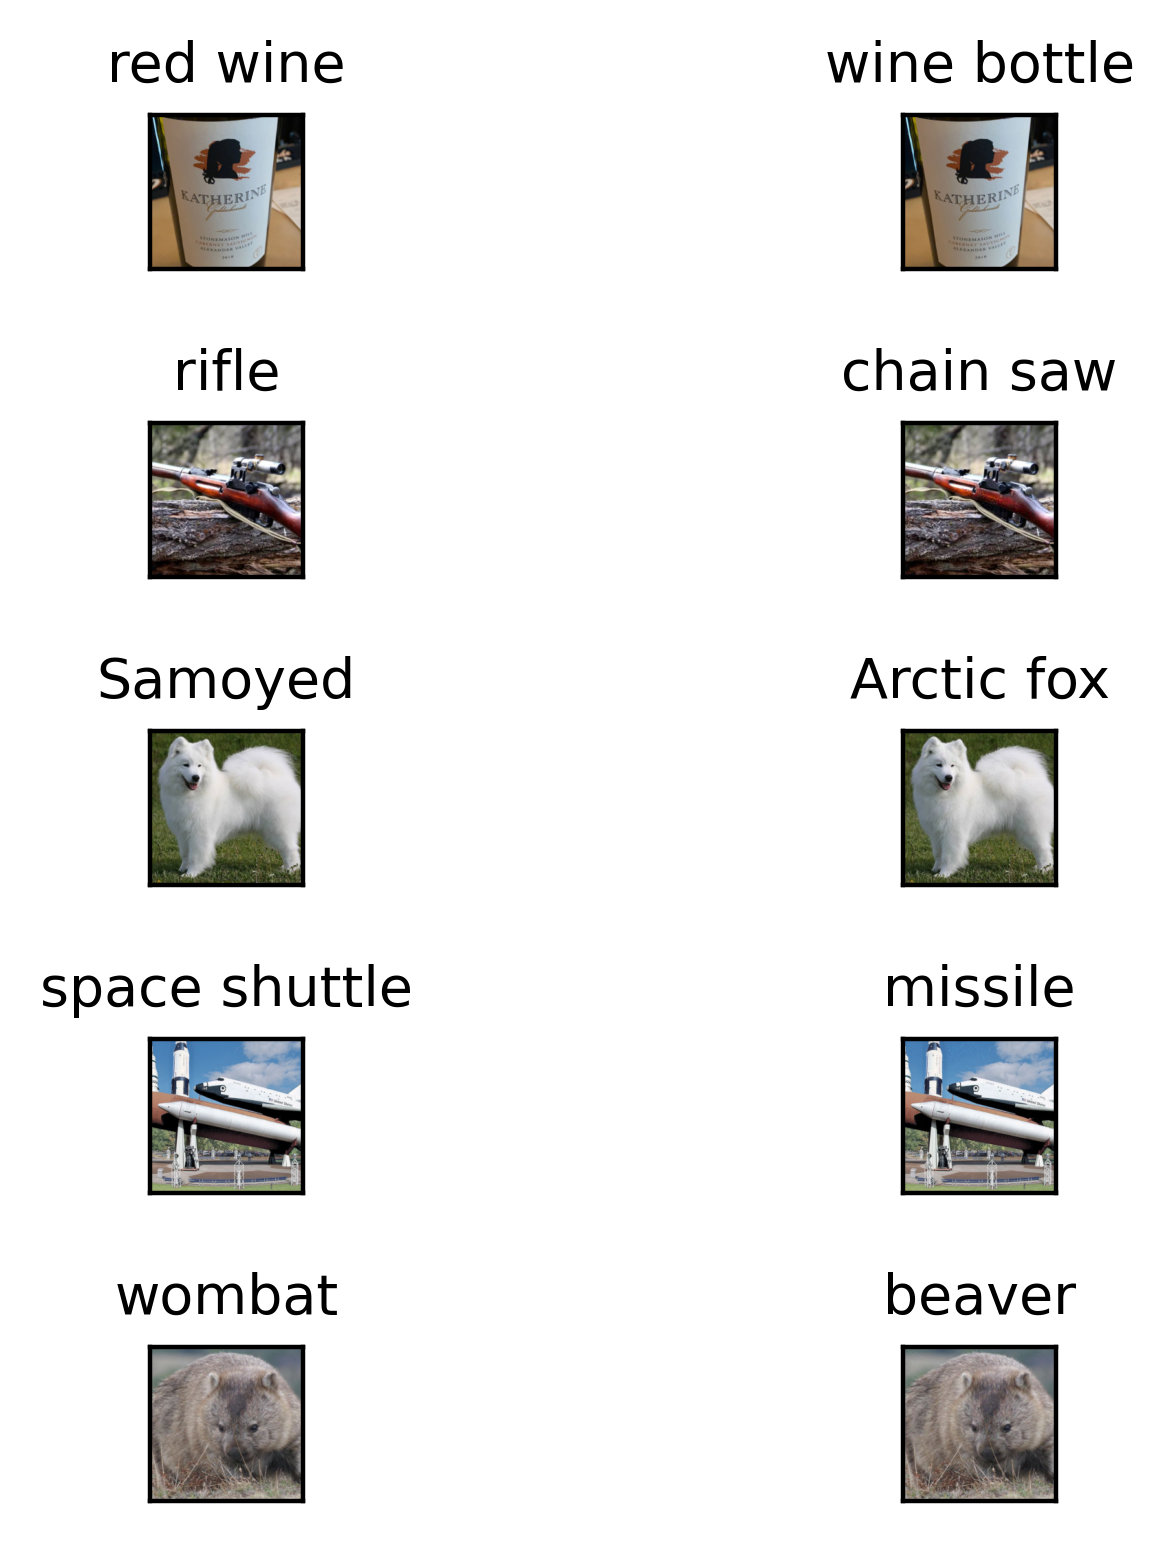

In [58]:
plt.figure()
f, axarr = plt.subplots(5,2, dpi=400) 
to_image = transforms.ToPILImage()
for i in range(5, 10):
    axarr[i-5, 0].imshow(to_image(inverse_transform(images[i][3][0])) )
    axarr[i-5, 0].axes.get_xaxis().set_visible(False)
    axarr[i-5, 0].axes.get_yaxis().set_visible(False)
    index, label = get_most_probable_class(images[i][3], network, False)
    axarr[i-5, 0].set_title(label.split(",")[0], fontsize=10)
    for j in range(len(attacks_algorithms)):
        axarr[i-5, j+1].imshow(inverse_transform(result[i][j][1][0]).permute(1, 2, 0).detach().numpy() )
        axarr[i-5, j+1].axes.get_xaxis().set_visible(False)
        axarr[i-5, j+1].axes.get_yaxis().set_visible(False)
        index, label = get_most_probable_class(result[i][j][1], network, False)
        axarr[i-5, j+1].set_title(label.split(",")[0], fontsize=10)
        plt.tight_layout()

In [61]:
for i in range(10):
    to_image(inverse_transform(images[i][3][0])).save("results/base_image_" + str(i) + ".png", format="png")


In [63]:
for i in range(10):
    for j in range(len(attacks_algorithms)):
        to_image(inverse_transform(result[i][j][1][0])).save("results/" + attacks_algorithms_name[j] + "_" + str(i)+".png", format="png")

In [67]:
import pickle
with open('result.pkl', 'rb') as f:
    result = pickle.load(f)
attacks_algorithms_name = ['fast gradient attack', 'simba']
attacks_algorithms = [fast_gradient_attack, simba_attack]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

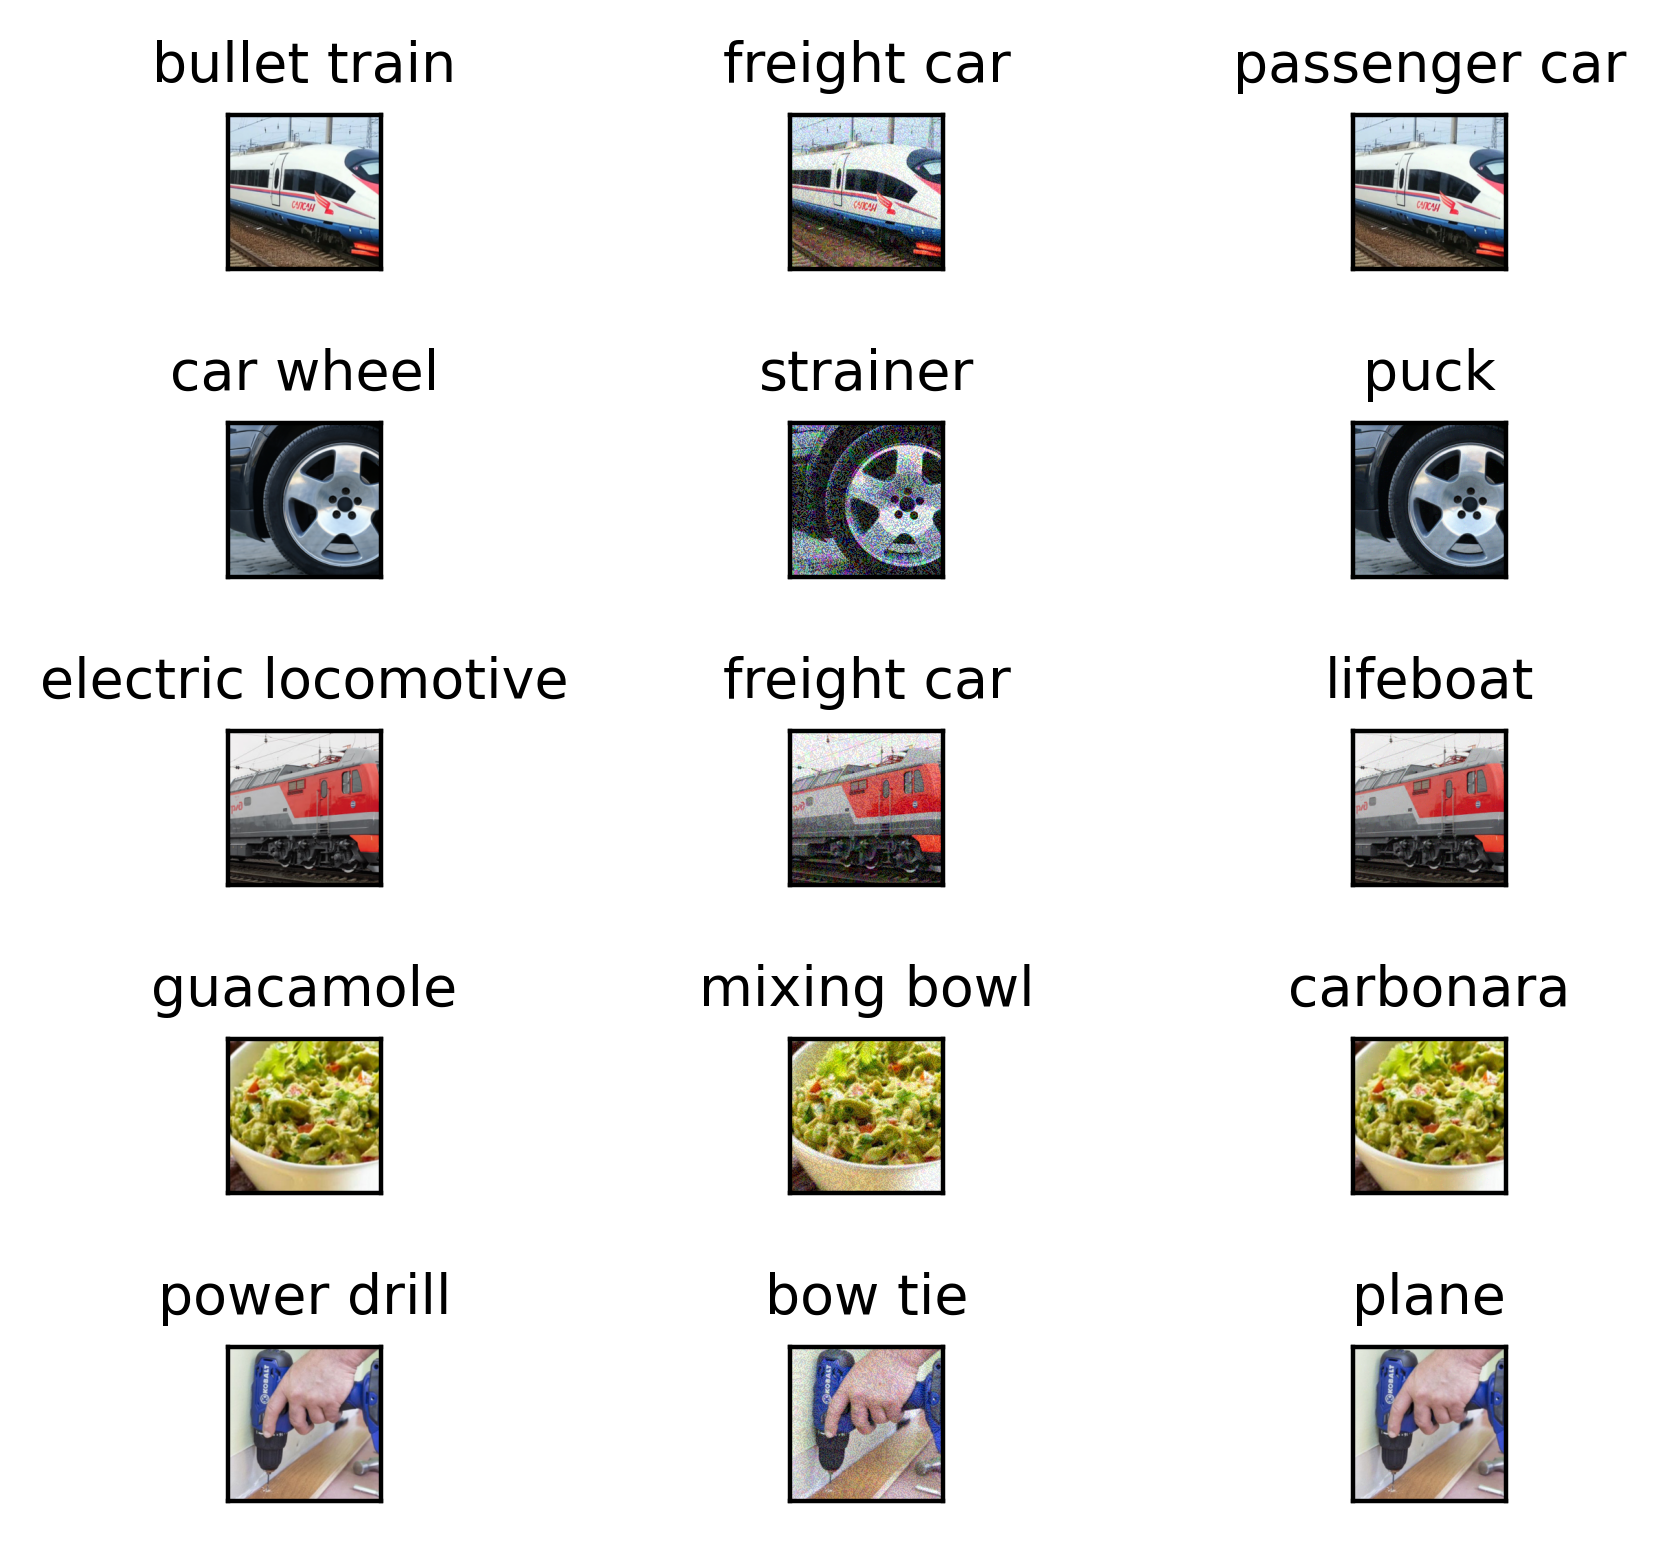

In [69]:
plt.figure()
f, axarr = plt.subplots(5,3, dpi=400) 
to_image = transforms.ToPILImage()
for i in range(5):
    axarr[i, 0].imshow(inverse_transform(images[i][3][0]).permute(1, 2, 0).detach().numpy() )
    axarr[i, 0].axes.get_xaxis().set_visible(False)
    axarr[i, 0].axes.get_yaxis().set_visible(False)
    index, label = get_most_probable_class(images[i][3], network, False)
    axarr[i, 0].set_title(label.split(",")[0], fontsize=10)
    for j in range(len(attacks_algorithms)):
        axarr[i, j+1].imshow(inverse_transform(result[i][j][1][0]).permute(1, 2, 0).detach().numpy() )
        axarr[i, j+1].axes.get_xaxis().set_visible(False)
        axarr[i, j+1].axes.get_yaxis().set_visible(False)
        index, label = get_most_probable_class(result[i][j][1], network, False)
        axarr[i, j+1].set_title(label.split(",")[0], fontsize=10)
        plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

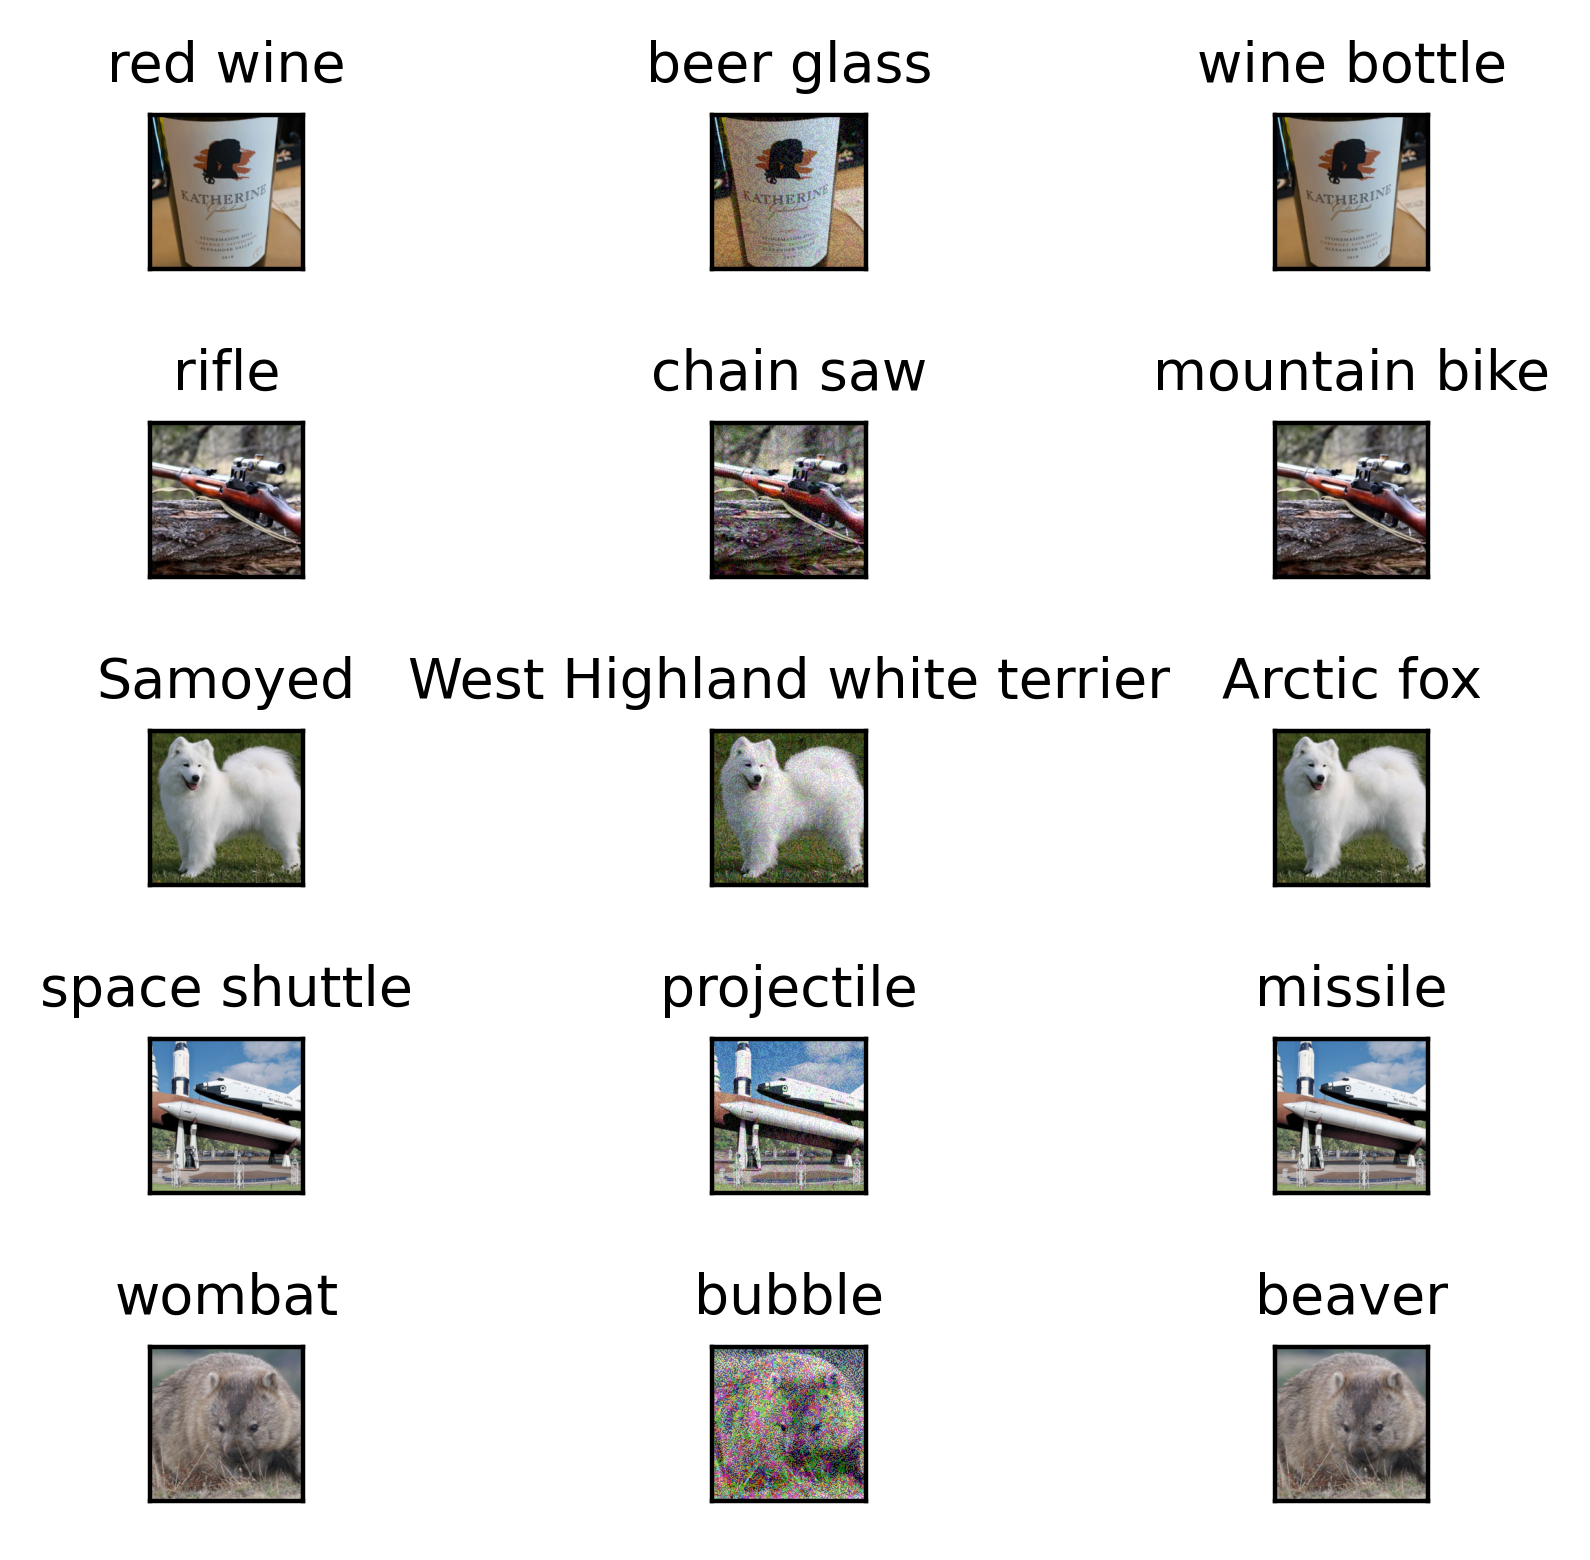

In [70]:
plt.figure()
f, axarr = plt.subplots(5,3, dpi=400) 
to_image = transforms.ToPILImage()
for i in range(5, 10):
    axarr[i-5, 0].imshow(to_image(inverse_transform(images[i][3][0])) )
    axarr[i-5, 0].axes.get_xaxis().set_visible(False)
    axarr[i-5, 0].axes.get_yaxis().set_visible(False)
    index, label = get_most_probable_class(images[i][3], network, False)
    axarr[i-5, 0].set_title(label.split(",")[0], fontsize=10)
    for j in range(len(attacks_algorithms)):
        axarr[i-5, j+1].imshow(inverse_transform(result[i][j][1][0]).permute(1, 2, 0).detach().numpy() )
        axarr[i-5, j+1].axes.get_xaxis().set_visible(False)
        axarr[i-5, j+1].axes.get_yaxis().set_visible(False)
        index, label = get_most_probable_class(result[i][j][1], network, False)
        axarr[i-5, j+1].set_title(label.split(",")[0], fontsize=10)
        plt.tight_layout()

In [71]:
for i in range(10):
    for j in range(len(attacks_algorithms)):
        to_image(inverse_transform(result[i][j][1][0])).save("results/" + attacks_algorithms_name[j] + "_" + str(i)+".png", format="png")